In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def read_text(filename):

  file = open(filename,mode='rt',encoding='utf-8')

  #read all text
  text = file.read()
  file.close()
  return text

In [3]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text('/content/deu.txt')
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
        'Wenn jemand Fremdes dir sagt, dass du dich wie ein Muttersprachler anhörst, bedeutet das wahrscheinlich: Er hat etwas an deinem Sprechen bemerkt, dass dich als Nicht-Muttersprachler verraten hat. Mit anderen Worten: Du hörst dich nicht wirklich wie ein Muttersprachler an.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #953936 (CK) & #3807493 

In [6]:
deu_eng = deu_eng[:50000,:2]

**TEXT PRE-PROCESSING**

In [7]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ['They come from Sweden.', 'Sie kommen aus Schweden.'],
       ['They could hardly see.', 'Sie konnten kaum etwas sehen.'],
       ["They didn't choose me.", 'Sie wählten mich nicht.']],
      dtype='<U537')

In [8]:
#Remove Punctuation

deu_eng[:,0] = [ s.translate(str.maketrans('','',string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [ s.translate(str.maketrans('','',string.punctuation)) for s in deu_eng[:,1]]

In [9]:
deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['They come from Sweden', 'Sie kommen aus Schweden'],
       ['They could hardly see', 'Sie konnten kaum etwas sehen'],
       ['They didnt choose me', 'Sie wählten mich nicht']], dtype='<U537')

In [10]:
#Convert to lower case

for i in range(len(deu_eng)):
  deu_eng[i,0] = deu_eng[i,0].lower()
  deu_eng[i,1] = deu_eng[i,1].lower()

In [11]:
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['they come from sweden', 'sie kommen aus schweden'],
       ['they could hardly see', 'sie konnten kaum etwas sehen'],
       ['they didnt choose me', 'sie wählten mich nicht']], dtype='<U537')

In [12]:
#Text to Sequence
eng_len = []
deu_len = []

for word in deu_eng[:,0]:
  eng_len.append(len(word.split()))

for word in deu_eng[:,1]:
  deu_len.append(len(word.split()))

In [13]:
len_df = pd.DataFrame({
    'eng_len':eng_len,
    'deu_len':deu_len
})

In [14]:
len_df

,eng_len,deu_len
0,1,1
1,1,1
2,1,2
3,1,1
4,1,1
...,...,...
49995,5,7
49996,4,5
49997,4,4
49998,4,5


<Figure size 720x504 with 0 Axes>

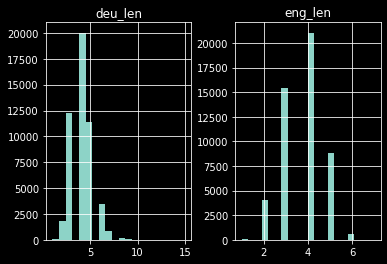

In [15]:
plt.figure(figsize=(10,7))
plt.style.use('dark_background')
len_df.hist(bins = 20)
plt.show()

In [16]:
max(eng_len)

7

In [17]:
max(deu_len)

15

In [18]:
#Tokenization

def tokenization(text):

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)
  return tokenizer

In [19]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6295


In [20]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10401


In [21]:
#Encode and Pad Sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

**MODEL BUILDING**

In [22]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [23]:
deu_length = 10
eng_length = 10
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [24]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [25]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [26]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics= ['accuracy'])

In [27]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=5, batch_size=128, validation_split = 0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 449s 14ms/step - loss: 2.3761 - accuracy: 0.6588 - val_loss: 2.0681 - val_accuracy: 0.6837
Epoch 2/5
32000/32000 [==============================] - 455s 14ms/step - loss: 1.8747 - accuracy: 0.7062 - val_loss: 1.7715 - val_accuracy: 0.7238
Epoch 3/5
32000/32000 [==============================] - 447s 14ms/step - loss: 1.6186 - accuracy: 0.7391 - val_loss: 1.6001 - val_accuracy: 0.7458
Epoch 4/5
32000/32000 [==============================] - 448s 14ms/step - loss: 1.4334 - accuracy: 0.7615 - val_loss: 1.4626 - val_accuracy: 0.7634
Epoch 5/5
32000/32000 [==============================] - 446s 14ms/step - loss: 1.2831 - accuracy: 0.7788 - val_loss: 1.3626 - val_accuracy: 0.7749


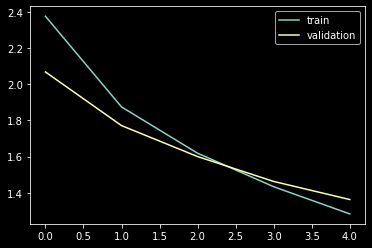

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

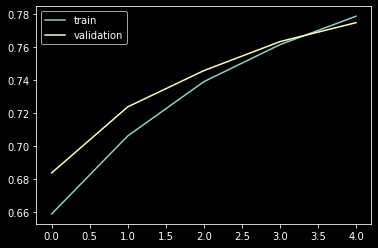

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

In [30]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [31]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [32]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [33]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [34]:
pred_df.head(15)

,actual,predicted
0,it cannot last long,it cant be long
1,am i right,im i right
2,guess who i am,where are we
3,were in town,were in the
4,tom runs the fastest,tom can his
5,i will vouch for him,im going to
6,can i spend the night,can i get it
7,please write it down,please it for
8,the water is hot,the is open
9,they always complain,they always busy
